##  Векторные представления слов и документов: word2vec, doc2vec и fasttext 


1. word2vec – векторное представление слова
2. как сделать вектор документа?
    * усреднить все вектора слов
    * усреднить все вектора слов с $tf-idf$ весами
    * doc2vec
3. fasttext – векторное представление $n$-грам



## Векторные представления слов (word embeddings)

Задача: получить представление слов $w_1,...,w_V \in W$ в виде векторов линейного пространства $\mathbb{R}^N$.


## word2Vec $-$ общая идея

Основная идея модели ****word2vec**** $-$  будем предсказывать вероятность слова по его окружению (контексту).


По слову $w$ предсказываем слово $w'$


$X$ – one-hot представление входного слова $w$

$y_i =  p(w' = w_i)$

$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$u_j = W' h$  – выходной слой

$p(w_j) = y_j = \frac{exp(u_j)}{\sum_i exp(u_i)} $ – искомая вероятность

## Модель CBOW (Continious bag of word)


Идея: будем предсказывать слово по его контексту.

Где:
$X_i$ – one-hot представление входного слова $w_i$
 
$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$y_i =  p(w' = w_i)$ $-$ искомая вероятность встретить слово $w_i$ в контексте $x_{C_1}...x_{C_k}$ 



## Модель Skip-gram

Идея: по слову $w_i$ будем предсказывать контекст слова. 

На вход модели подается слово и слова, попавшие с ним в один контекст. 
![img](img/skip_gram_window.png)

Где:
$X_k$ – one-hot представление входного слова $w$
 
$W = |V \times N | $ – матрица весов между входным и скрытым слоем

$h =x^T W$ – скрытый слой – выбирает одну строку из матрицы $W_{}$

$W' = |N \times V| $ – матрица весов между скрытым слоем и выходным   

$y_i =  p(w' = w_i)$ $-$ искомая вероятность встретить слово $w_i$ в одном контексте со словом $X_k$ 

Векторные представления слов $-$ строки матрицы весов нейронной сети.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')
random.seed(1228)

%matplotlib inline

Скачиваем куски датасета твитов ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/ilkte35m35l38mr/negative.sql).

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [6]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [ ]:
df_neg = pd.read_csv("negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("positive.csv", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df_pos['text'] = df_pos[3]
df_neg['text'] = df_neg[3]
df = pd.concat([df_neg, df_pos])
df = df[['text', 'sent']]
%time df.text = df.text.apply(words_only)
%time df.text = df.text.apply(lemmatize)

In [12]:
df_neg = pd.read_csv("negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("positive.csv", sep=';', header = None, usecols = [3])
df_neg.head()

,3
0,на работе был полный пиддес :| и так каждое за...
1,"Коллеги сидят рубятся в Urban terror, а я из-з..."
2,@elina_4post как говорят обещаного три года жд...
3,"Желаю хорошего полёта и удачной посадки,я буду..."
4,"Обновил за каким-то лешим surf, теперь не рабо..."


In [7]:
# Data load for Windows users
df = pd.read_csv('processed_text.csv', index_col = 0)

In [8]:
print(df.shape)
df.head()

(226834, 2)


,text,sent
0,на работа быть полный пиддеса :| и так каждый ...,neg
1,коллега сидеть рубиться в Urban terror а я из ...,neg
2,elina_ post как говорить обещаной три год ждат...,neg
3,желать хороший пол тот и удачный посадка я быт...,neg
4,обновлять за какой то леший surf теперь не раб...,neg


In [9]:
df.tail()

,text,sent
114906,спать в родительский дом на свой кровать просы...,pos
114907,RT jebesilofyt: эх мы немного решать сокращать...,pos
114908,что происходить со я когда в эфир proactivefm ...,pos
114909,любимый я подарить ты этот звезда имя какой зв...,pos
114910,Ma_che_rie посмотреть непытайтесьпокинутьомск ...,pos


In [10]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

## Обучение модели в gensim

texts[0]

In [13]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)
model.save("word2v.model")

Wall time: 24.8 s


Загружаем обученную модель (для скорости):

In [ ]:
# from gensim.models import Word2Vec
# model = Word2Vec.load("sent_w2v.model") 

In [14]:
model.most_similar("сессия")

[('экзамен', 0.8852670192718506),
 ('зачет', 0.8226255178451538),
 ('учеба', 0.8022707104682922),
 ('каникулы', 0.7999930381774902),
 ('четверть', 0.7795166373252869),
 ('практика', 0.7319642901420593),
 ('готовиться', 0.7284587621688843),
 ('понедельник', 0.7242501378059387),
 ('семестр', 0.7197004556655884),
 ('сдавать', 0.7162190675735474)]

In [15]:
vec = (model['университет'] - model['студент'] + model['школьник'])/3
model.wv.similar_by_vector(vec)

[('университет', 0.8694007396697998),
 ('поступление', 0.8577466607093811),
 ('мисс', 0.7901598215103149),
 ('конгениальность!!!', 0.7901025414466858),
 ('палата', 0.7895925045013428),
 ('полонский', 0.7728846669197083),
 ('чат', 0.7701342105865479),
 ('макси', 0.7692163586616516),
 ('аквариум', 0.7663450241088867),
 ('стиль', 0.7637368440628052)]

In [17]:
vec = (model['спальня'] - model['спать'] + model['пить'])/3
model.wv.similar_by_vector(vec)

[('белый', 0.43419554829597473),
 ('игрушка', 0.4112526774406433),
 ('телефон:D', 0.4013959765434265),
 ('O_o', 0.39559727907180786),
 ('зеленый', 0.390394002199173),
 ('золотой', 0.38713833689689636),
 ('помощь', 0.37748733162879944),
 ('красный', 0.37130656838417053),
 ('ее', 0.3710832893848419),
 ('фартук', 0.3702307939529419)]

In [21]:
model.doesnt_match("лекция семинар домашка обед".split())

'обед'

### Визуализация пространства слов 

In [22]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words)

['я', 'не', 'и', 'в', 'на', 'что', 'RT', 'а', 'http://t', 'быть', 'ты', 'с', 'как', 'то', 'у', 'это', ':(', 'так', ':', ')', '(', 'но', 'все', 'он', 'ну', 'по', 'мы', ':)', 'мой', 'за', 'весь', 'хотеть', 'такой', ':D', 'уже', 'этот', 'вот', 'же', 'только', 'день', 'да', 'кто', 'еще', 'сегодня', 'она', 'бы', 'когда', 'мочь', 'они', 'вы', 'к', 'очень', 'из', 'просто', 'нет', 'один', 'знать', 'какой', 'от', 'год', 'если', 'теперь', 'любить', 'человек', 'свой', 'co/', 'даже', 'о', 'надо', 'до', 'новый', 'завтра', 'тоже', 'там', 'вс', 'тот', 'вообще', '((', 'для', 'самый', 'хороший', 'себя', 'хорошо', 'сейчас', '))', 'почему', 'делать', 'который', 'думать', 'много', 'раз', 'понимать', 'сказать', '(((', 'блин', 'смотреть', 'без', 'время', 'спать', 'спасибо', 'или', 'тут', 'утро', ')))', 'говорить', 'идти', 'сидеть', 'со', 'пойти', 'давать', 'про', 'ничто', 'писать', 'сделать', 'всегда', 'можно', 'жизнь', 'друг', 'первый', 'скоро', 'сам', 'наш', 'где', 'мама', 'потом', 'школа', '!', 'час', 'т

In [ ]:
model['рабочий']

In [23]:
top_words_vec = model[top_words]

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [25]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

### Кластеризация слов 

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(top_words_vec)

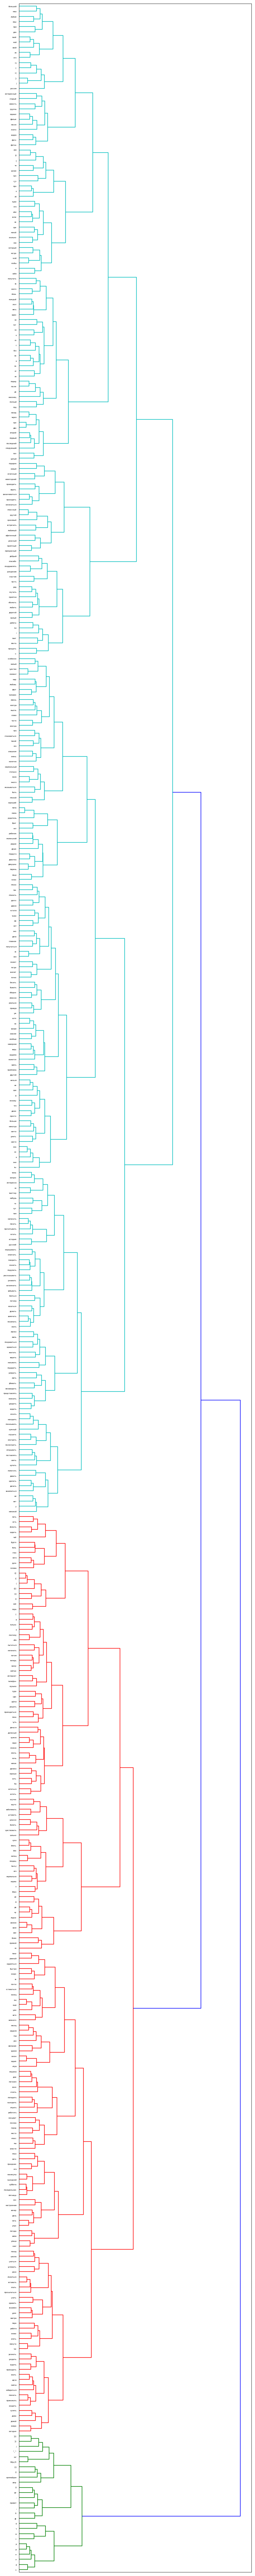

In [27]:
from scipy.cluster.hierarchy import  ward, dendrogram

linkage_matrix = ward(dist) 

fig, ax = plt.subplots(figsize=(10, 100)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=top_words);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_cluster.png', dpi=200) #save figure as ward_clusters

## Классификация текстов 

По мотивам http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [28]:
X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [35]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])



In [ ]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
#         your
#         code
#         here



In [29]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
#rfc_w2v_tfidf = Pipeline([
#    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
#    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [38]:
rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

In [40]:
X_test

array(['zayns_wife_ aw спасибо большой надеяться ты в школа сильно не нагружать :(',
       'RT annychilly: я столько цветок еще никогда не дарить) спасибо вы любимый ребятки:',
       'все добрый утро хороший настроение и удача на пробный экзе )',
       ...,
       'RT YYYaanaaa: агида бригада проходить успешно)хотя я и лохануться)))с победа мы:',
       'антон красовский: ходорковский испытание прощение: http://t co/iTHLnbfbTg экран мироточить(',
       'куеила игра стрелялка стоять дофига начинать грузить ничто не получаться( печально'],
      dtype='<U182')

Precision:   0.79
Recall:   0.79
F1-measure:   0.79
Accuracy:   0.79
             precision    recall  f1-score   support

        neg       0.77      0.81      0.79     36755
        pos       0.81      0.77      0.79     38101

avg / total       0.79      0.79      0.79     74856



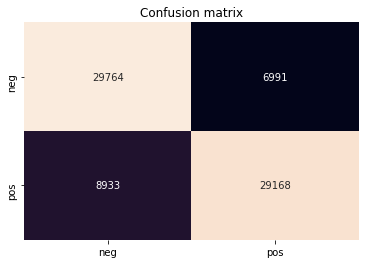

In [39]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [ ]:
rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

In [ ]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()